In [3]:
import pandas as pd
import numpy as np
import requests 
from bs4 import BeautifulSoup
import urllib.request
import os
from pyquery import PyQuery as pq
import pickle
from selenium import webdriver
import datetime as dt
import time
import calendar
import scipy.stats as ss
from pandas import Series
import math
import matplotlib.pyplot as plt

In [4]:
#整理資料
origin_list=pd.read_csv("Materials Equity ETF List (62).csv",index_col=22,parse_dates=True)
origin_list2=pd.read_csv("Telecom Equity ETF List (10).csv",index_col=22,parse_dates=True)
need_list=pd.concat([origin_list,origin_list2])

In [5]:
#切出symbol欄&ETF名稱欄
symbol_list = need_list['Symbol'].reset_index()['Symbol']
name_list = need_list['ETF Name'].reset_index()['ETF Name']
all_ETF=need_list["Symbol"].values

In [6]:
all_ETF

array(['XLB', 'IYM', 'IGE', 'VAW', 'PKB', 'XHB', 'ITB', 'GDX', 'XME',
       'MXI', 'PYZ', 'SLX', 'RTM', 'UYM', 'SMN', 'FXZ', 'MOO', 'CUT',
       'WOOD', 'HAP', 'PSAU', 'PAGG', 'FLM', 'GRES', 'GDXJ', 'CHIM',
       'FTRI', 'FTAG', 'SBM', 'PSCM', 'SIL', 'COPX', 'LIT', 'GNR', 'REMX',
       'GOEX', 'URA', 'NUGT', 'DUST', 'CROP', 'SOIL', 'GUNR', 'PICK',
       'RING', 'SLVP', 'VEGI', 'SILJ', 'JNUG', 'JDST', 'FMAT', 'SGDM',
       'GDXX', 'GDXS', 'HOML', 'SGDJ', 'NAIL', 'NANR', 'VOX', 'ERUS',
       'IYZ', 'FCOM', 'IXP', 'XTL', 'WBIF', 'FONE', 'LTL'], dtype=object)

In [7]:
#combine ETF daily data
#use the combined data to build the weekly and monthly ETF return 
def combine_daily_data(ETF):
    com_data=pd.DataFrame()
    for s in range(len(ETF)):
        read = "./data/"+ ETF[s] +".csv"
        data = pd.read_csv(read,index_col=0,parse_dates=True)["Adj Close"]
        com_data = pd.concat([com_data,data],axis=1)
    com_data.columns = ETF
    return com_data

Daily_ETF = combine_daily_data(all_ETF)

In [8]:
#fill in the no-trade dates of ETF
day=Daily_ETF.index[0]
n=0
while day!=Daily_ETF.index[-1]:
    if (Daily_ETF.index[n+1]-Daily_ETF.index[n]).days !=1:
        for i in range(1,(Daily_ETF.index[n+1]-Daily_ETF.index[n]).days):
            Daily_ETF.loc[Daily_ETF.index[n]+dt.timedelta(i)]=Daily_ETF.loc[Daily_ETF.index[n]]
    Daily_ETF=Daily_ETF.sort_index()
    n = n+(Daily_ETF.index[n+1]-Daily_ETF.index[n]).days
    day=Daily_ETF.index[n]

In [9]:
# week index is to select every Friday and month index is the first day of every month
week_index=[]
for i in range(Daily_ETF.shape[0]):
    if Daily_ETF.index[i].isoweekday()==5:
        week_index.append(Daily_ETF.index[i])
month_index=[]
for i in range(Daily_ETF.shape[0]):
    if Daily_ETF.index[i].day==1:
        month_index.append(Daily_ETF.index[i])

In [10]:
#fill in the no-trade dates of 3 month US bond (using its value as risk-free interest rate) 
riskless_rate=pd.read_csv("USG3M.csv",index_col=0,parse_dates=True, )
USG3M=riskless_rate["Price"].reset_index("Date")
USG3M.set_index("Date" , inplace=True)
USG3M=USG3M[::-1]
n=0
day=USG3M.index[0]
while day!=USG3M.index[-1]:
    if (USG3M.index[n+1]-USG3M.index[n]).days !=1:
        for i in range(1,(USG3M.index[n+1]-USG3M.index[n]).days):
            USG3M.loc[USG3M.index[n]+dt.timedelta(i)]=USG3M.loc[USG3M.index[n]]
    USG3M=USG3M.sort_index()
    n = n+(USG3M.index[n+1]-USG3M.index[n]).days
    day=USG3M.index[n]

In [11]:
weekly_ETF=Daily_ETF.loc[week_index]
monthly_ETF=Daily_ETF.loc[month_index]
wr=weekly_ETF/weekly_ETF.shift(1)-1
mr=monthly_ETF/monthly_ETF.shift(1)-1
wUSG3M = USG3M.loc[week_index] / 100 / 52
mUSG3M = USG3M.loc[month_index] / 100 / 12

In [12]:
#Portfolio performance evaluation with generalized Sharpe ratios:
#Beyond the mean and variance
#For weekly data
#3 years for a round

# potential bug r_f , negative number in the sqrt

wASKSR = []

for now, symbol in enumerate(symbol_list):
    wASKSR.append([])
    List = wr[symbol]
    l = len(List)
    for i in range(l-52*3):
        if(not ( float("-inf") <List[i] < float("inf") )): #nan
            wASKSR[now].append(float('nan'))
            continue
        else:
            X = []
            for j in range(i, i+52*3):
                X.append(List[j])
            X = Series(X)
            #computing ASKSR
            K = X.kurt() #Kurt
            S = X.skew() #Skew
            std = X.std() #standard deviation

            #compute alpha
            tmp = 3*K-4*S**2
            if tmp < 0 :
                tmp *= -1
            alpha = 3*math.sqrt(tmp) / (std**2 * (3*K - 5 * S**2))

            #compute beta
            beta =  3 * S / (std*(3*K-5*S**2))

            #compute eta (n with right tail)
            eta = X.mean() - 3*S*std/(3*K-4*S**2)

            #compute delta
            tmp = 3*K-5*S**2
            if tmp < 0:
                tmp *= -1
            delta = 3 * std * math.sqrt(tmp)/(3*K - 4*S**2)

            r_f = wUSG3M["Price"][i+52*3] # risk-free interest rate per unit of time

            # a* x lambda 
            a_star_multiple_lambda =  (beta + alpha*(eta - r_f) / math.sqrt(delta**2 + (eta - r_f)**2) )
            #print(a_star_multiple_lambda)

            #compute psi
            tmp = alpha**2 - beta**2
            if tmp < 0:
                tmp *= -1
            psi = math.sqrt(tmp)

            #equation 38
            tmp = alpha**2-(beta-a_star_multiple_lambda)**2
            if tmp < 0 :
                tmp *= -1
            tmp = 2*(a_star_multiple_lambda*(eta - r_f) - delta*(psi - math.sqrt(tmp)))
            if tmp < 0:
                tmp *= -1 
            ASKSR = math.sqrt(tmp)
            wASKSR[now].append(ASKSR)
print("Weekly ASKSR done")

Weekly ASKSR done


In [13]:
#Portfolio performance evaluation with generalized Sharpe ratios:
#Beyond the mean and variance
#For monthly data
#3 years for a round 
mASKSR = []
for now, symbol in enumerate(symbol_list):
    mASKSR.append([])
    List = mr[symbol]
    l = List.shape[0]
    for i in range(l - 12*3):
        if(not ( float("-inf") <List[i] < float("inf") )): #nan
            mASKSR[now].append(float('nan'))
            continue
        X = []
        for j in range(i, i+12*3):
            X.append(List[j])
        X = Series(X)
        #computing ASKSR
        K = X.kurt() #Kurt
        S = X.skew() #Skew
        std = X.std() #stdev
        
        #compute alpha
        tmp = 3*K-4*S**2
        if tmp < 0 :
            tmp *= -1
        alpha = 3*math.sqrt(tmp) / (std**2 * (3*K - 5 * S**2))
        
        #compute beta
        beta =  3 * S / (std*(3*K-5*S**2))
        
        #compute eta (n with right tail)
        eta = X.mean() - 3*S*std/(3*K-4*S**2)
        
        #compute delta
        tmp = 3*K-5*S**2
        if tmp < 0:
            tmp *= -1
        delta = 3 * std * math.sqrt(tmp)/(3*K - 4*S**2)
        
        r_f = mUSG3M["Price"][i+12*3] # risk-free interest rate per unit of time

        # a* x lembda
        a_star_multiple_lambda =  (beta + alpha*(eta - r_f) / math.sqrt(delta**2 + (eta - r_f)**2) )
        
        #compute psi
        tmp = alpha**2 - beta**2
        if tmp < 0:
            tmp *= -1
        psi = math.sqrt(tmp)
        #print(psi)
        
        # equation 38
        tmp = alpha**2-(beta-a_star_multiple_lambda)**2
        if tmp < 0 :
            tmp *= -1
        tmp = 2*(a_star_multiple_lambda*(eta - r_f) - delta*(psi - math.sqrt(tmp)))
        if tmp < 0:
            tmp *= -1 
        ASKSR = math.sqrt(tmp)
        #print("TIME:",List.index[i+52*3],"ASKSR:", ASKSR)
        mASKSR[now].append(ASKSR)
print("monthly ASKSR done")

monthly ASKSR done


In [14]:
#2011 JBF omega performance messure ...
#we need Sharpe_omega(L) which equals to omega_x(L) - 1
#F(.) is the cdf of the asset return X defined on the interval (a,b)
#and omega_x(L) = ( integrate from L to b : (1-F(x))dx) / ( integrate from a to L : F(x)dx )
#where L is the return threshold selected by the investor 
#for weekly:
wOmega = []
for now, symbol in enumerate(symbol_list):
    wOmega.append([])
    List = wr[symbol]
    l = List.shape[0]
    for i in range(l-52*3):
            
        L =  wUSG3M["Price"][i+52*3] #risk-free interest rate 
        
        if(not ( float("-inf") <List[i] < float("inf") )): #nan
            wOmega[now].append(float('nan'))
            continue
        X = []
        for j in range(i, i+52*3):
            X.append(List[j])
        X.sort()
        a = X[0]
        b = X[len(X)-1]
        # using 0.001 as a minimum interval 
        left_part = 0
        right_part = 0
        for i in range(len(X)):
            if(X[i] < L):
                left_part +=  L - X[i]
            else :
                right_part += X[i] - L
        omega = right_part / left_part
        wOmega[now].append(omega)
print("Weekly omega done")

Weekly omega done


In [15]:
#2011 JBF omega performance messure ...
#we need Sharpe_omega(L) which equals to omega_x(L) - 1
#F(.) is the cdf of the asset return X defined on the interval (a,b)
#and omega_x(L) = ( integrate from L to b : (1-F(x))dx) / ( integrate from a to L : F(x)dx )
#where L is the return threshold selected by the investor 
#for monthly:
mOmega = []
for now, symbol in enumerate(symbol_list):
    mOmega.append([])
    List = mr[symbol]
    l = List.shape[0]
    for i in range(l-12*3):
            
        L =  mUSG3M["Price"][i+12*3] #risk-free interest rate 
        
        if(not ( float("-inf") <List[i] < float("inf") )): #nan
            mOmega[now].append(float('nan'))
            continue
        X = []
        for j in range(i, i+12*3):
            X.append(List[j])
        X.sort()
        a = X[0]
        b = X[len(X)-1] 
        left_part = 0
        right_part = 0
        for i in range(len(X)):
            if(X[i] < L):
                left_part +=  L - X[i]
            else :
                right_part += X[i] - L
        omega = right_part / left_part
        mOmega[now].append(omega)
print("Monthly omega done")

Monthly omega done


In [16]:
# time range 
wtime = []
for i in range(len(weekly_ETF.index)-52*3) :
    wtime.append(weekly_ETF.index[i+52*3])
mtime = []
for i in range(len(monthly_ETF.index)-12*3) :
    mtime.append(monthly_ETF.index[i+12*3])

In [17]:
#arranging the data above(in pandas.dataframe)
mOmega_dic = {}
mOmega_dic.update({'Date' : mtime})
for i in range(len(symbol_list)):
    mOmega_dic.update({symbol_list[i] : mOmega[i]})

mOmega_df = pd.DataFrame.from_dict(mOmega_dic)
mOmega_df.set_index('Date', inplace=True)
#print(mOmega_df)

wOmega_dic = {}
wOmega_dic.update({ "Date" : wtime})
for i in range(len(symbol_list)):
    wOmega_dic.update({symbol_list[i] : wOmega[i]})
wOmega_df = pd.DataFrame.from_dict(wOmega_dic)
wOmega_df.set_index('Date', inplace=True)
#print(wOmega_df)

mASKSR_dic = {}
mASKSR_dic.update({ "Date" : mtime})
for i in range(len(symbol_list)):
    mASKSR_dic.update({symbol_list[i] : mASKSR[i]})
    
mASKSR_df = pd.DataFrame.from_dict(mASKSR_dic)
mASKSR_df.set_index('Date', inplace=True)
#print(mASKSR_df)

wASKSR_dic = {}

wASKSR_dic.update({ "Date" : wtime})
for i in range(len(symbol_list)):
    wASKSR_dic.update({symbol_list[i] : wASKSR[i]})
wASKSR_df = pd.DataFrame.from_dict(wASKSR_dic)
wASKSR_df.set_index('Date', inplace=True)
#print(wASKSR_df)

In [18]:
# ranking the weekly omega
Ranking_wOmega = []
reverse_ranking = []
for i in range(len(wtime)):
    Ranking_wOmega.append([])

for i in range(len(wtime)):
    tmp = []
    nan_num = 0
    for j in range(len(symbol_list)):
        tmp.append(wOmega[j][i])
    rank = ss.rankdata(tmp)
    for j in range(len(symbol_list)):
        Ranking_wOmega[i].append(int ( len(symbol_list) - rank[j] + 1) )
    count = 0
    for j in range(len(symbol_list)):
        if(not ( float("-inf") < wOmega[j][i] < float("inf") )) : #nan
            Ranking_wOmega[i][j] = float("nan")
            count += 1
    # if nan exists, reranking the data
    for j in range(len(symbol_list)):
        if( float("-inf") < wOmega[j][i] < float("inf") ) : #nan
            Ranking_wOmega[i][j] -= count

Trans_Ranking = []
for i in range(len(symbol_list)):
    Trans_Ranking.append([])
    for j in range(len(wtime)):
            Trans_Ranking[i].append( Ranking_wOmega[j][i])
    
wOmega_ranking_dic = {}
wOmega_ranking_dic.update({ "Date" : wtime})
for i in range(len(symbol_list)):
    wOmega_ranking_dic.update({symbol_list[i] : Trans_Ranking[i]})
wOmega_ranking_df = pd.DataFrame.from_dict(wOmega_ranking_dic)
wOmega_ranking_df.set_index('Date', inplace=True)
print(wOmega_ranking_df)

             XLB   IYM   IGE   VAW   PKB   XHB   ITB   GDX   XME   MXI  ...   \
Date                                                                    ...    
2017-05-12   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
2017-05-19  16.0  25.0  51.0  14.0   2.0   8.0   5.0  30.0  42.0  37.0  ...    
2017-05-26  20.0  28.0  51.0  15.0   4.0  11.0   5.0  29.0  42.0  36.0  ...    
2017-06-02  19.0  29.0  52.0  18.0   6.0  12.0   5.0  25.0  42.0  37.0  ...    
2017-06-09  20.0  28.0  53.0  17.0   6.0  13.0   5.0  26.0  42.0  37.0  ...    
2017-06-16  16.0  24.0  53.0  12.0   6.0  11.0   5.0  28.0  41.0  36.0  ...    
2017-06-23  18.0  23.0  55.0  16.0   6.0  10.0   4.0  31.0  42.0  36.0  ...    
2017-06-30  16.0  23.0  55.0  15.0   6.0  11.0   4.0  31.0  42.0  36.0  ...    
2017-07-07  17.0  24.0  55.0  15.0   3.0  11.0   2.0  31.0  41.0  37.0  ...    
2017-07-14  15.0  23.0  56.0  14.0   2.0   7.0   1.0  33.0  40.0  31.0  ...    
2017-07-21  15.0  22.0  57.0  14.0   2.0

In [19]:
# ranking the monthly omega
Ranking_mOmega = []
reverse_ranking = []
for i in range(len(mtime)):
    Ranking_mOmega.append([])
    
for i in range(len(mtime)):
    #print(i)
    tmp = []
    nan_num = 0
    for j in range(len(symbol_list)):
        tmp.append(mOmega[j][i])
    rank = ss.rankdata(tmp)
    for j in range(len(symbol_list)):
        Ranking_mOmega[i].append(int ( len(symbol_list) - rank[j] + 1) )
    count = 0
    for j in range(len(symbol_list)):
        if(not ( float("-inf") < mOmega[j][i] < float("inf") )) : #nan
            Ranking_mOmega[i][j] = float("nan")
            count += 1
    # if nan exists, reranking the data
    for j in range(len(symbol_list)):
        if( float("-inf") < mOmega[j][i] < float("inf") ) : #nan
            Ranking_mOmega[i][j] -= count
    #print(Ranking_mOmega[i])

Trans_Ranking = []
for i in range(len(symbol_list)):
    Trans_Ranking.append([])
    for j in range(len(mtime)):
            Trans_Ranking[i].append( Ranking_mOmega[j][i])
    
mOmega_ranking_dic = {}
mOmega_ranking_dic.update({ "Date" : mtime})
for i in range(len(symbol_list)):
    mOmega_ranking_dic.update({symbol_list[i] : Trans_Ranking[i]})
mOmega_ranking_df = pd.DataFrame.from_dict(mOmega_ranking_dic)
mOmega_ranking_df.set_index('Date', inplace=True)
print(mOmega_ranking_df)

             XLB   IYM   IGE   VAW   PKB   XHB   ITB   GDX   XME   MXI  ...   \
Date                                                                    ...    
2017-06-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
2017-07-01  20.0  27.0  53.0  17.0   5.0  13.0   6.0  26.0  40.0  37.0  ...    
2017-08-01  17.0  26.0  55.0  15.0   4.0  12.0   6.0  31.0  41.0  36.0  ...    
2017-09-01  16.0  23.0  57.0  14.0   4.0   8.0   1.0  33.0  43.0  31.0  ...    
2017-10-01  18.0  24.0  58.0  16.0   5.0  10.0   3.0  31.0  45.0  29.0  ...    
2017-11-01  19.0  22.0  53.0  15.0   3.0   8.0   2.0  32.0  46.0  27.0  ...    
2017-12-01  16.0  23.0  53.0  14.0   2.0  13.0   1.0  28.0  49.0  25.0  ...    
2018-01-01  18.0  23.0  52.0  14.0   1.0  11.0   2.0  33.0  45.0  25.0  ...    
2018-02-01  20.0  25.0  52.0  15.0   2.0  19.0   3.0  33.0  42.0  21.0  ...    
2018-03-01  17.0  21.0  51.0  15.0   2.0  25.0   4.0  46.0  33.0  19.0  ...    
2018-04-01  25.0  27.0  52.0  16.0  10.0

In [20]:
# ranking the weekly ASKSR
Ranking_wASKSR = []
reverse_ranking = []
for i in range(len(wtime)):
    Ranking_wASKSR.append([])

for i in range(len(wtime)):
    #print(i)
    tmp = []
    nan_num = 0
    for j in range(len(symbol_list)):
        tmp.append(wASKSR[j][i])
    rank = ss.rankdata(tmp)
    for j in range(len(symbol_list)):
        Ranking_wASKSR[i].append(int ( len(symbol_list) - rank[j] + 1) )
    count = 0
    for j in range(len(symbol_list)):
        if(not ( float("-inf") < wASKSR[j][i] < float("inf") )) : #nan
            Ranking_wASKSR[i][j] = float("nan")
            count += 1
    # if nan exists, reranking the data
    for j in range(len(symbol_list)):
        if( float("-inf") < wASKSR[j][i] < float("inf") ) : #nan
            Ranking_wASKSR[i][j] -= count
    #print(Ranking_wOmega[i])

Trans_Ranking = []
for i in range(len(symbol_list)):
    Trans_Ranking.append([])
    for j in range(len(wtime)):
            Trans_Ranking[i].append( Ranking_wASKSR[j][i])
    
wASKSR_ranking_dic = {}
wASKSR_ranking_dic.update({ "Date" : wtime})
for i in range(len(symbol_list)):
    wASKSR_ranking_dic.update({symbol_list[i] : Trans_Ranking[i]})
wASKSR_ranking_df = pd.DataFrame.from_dict(wASKSR_ranking_dic)
wASKSR_ranking_df.set_index('Date', inplace=True)
print(wASKSR_ranking_df)

             XLB   IYM   IGE   VAW   PKB   XHB   ITB   GDX   XME   MXI  ...   \
Date                                                                    ...    
2017-05-12   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
2017-05-19  14.0  17.0  54.0  18.0  55.0   7.0  16.0  53.0   5.0  56.0  ...    
2017-05-26  15.0  17.0  53.0  18.0  57.0   7.0  16.0  54.0   5.0  56.0  ...    
2017-06-02  15.0  16.0  50.0  18.0  58.0   7.0  17.0  54.0   5.0  57.0  ...    
2017-06-09  14.0  15.0  50.0  17.0  58.0   8.0  16.0  54.0   5.0  57.0  ...    
2017-06-16  11.0  12.0  49.0  14.0  57.0   9.0  18.0  53.0   5.0  58.0  ...    
2017-06-23  13.0  16.0  50.0  17.0  58.0   9.0  15.0  52.0   5.0  57.0  ...    
2017-06-30  13.0  14.0  47.0  15.0  58.0   9.0  18.0  53.0   4.0  57.0  ...    
2017-07-07  14.0  15.0  48.0  18.0  58.0   9.0  17.0  52.0   5.0  56.0  ...    
2017-07-14  15.0  16.0  50.0  17.0  56.0  10.0  20.0  51.0   5.0  58.0  ...    
2017-07-21  14.0  16.0  50.0  17.0  57.0

In [21]:
# ranking the monthly ASKSR
Ranking_mASKSR = []
reverse_ranking = []
for i in range(len(mtime)):
    Ranking_mASKSR.append([])

for i in range(len(mtime)):
    #print(i)
    tmp = []
    nan_num = 0
    for j in range(len(symbol_list)):
        tmp.append(mASKSR[j][i])
    rank = ss.rankdata(tmp)
    for j in range(len(symbol_list)):
        Ranking_mASKSR[i].append(int ( len(symbol_list) - rank[j] + 1) )
    count = 0
    for j in range(len(symbol_list)):
        if(not ( float("-inf") < mASKSR[j][i] < float("inf") )) : #nan
            Ranking_mASKSR[i][j] = float("nan")
            count += 1
    # if nan exists, reranking the data
    for j in range(len(symbol_list)):
        if( float("-inf") < mASKSR[j][i] < float("inf") ) : #nan
            Ranking_mASKSR[i][j] -= count

Trans_Ranking = []
for i in range(len(symbol_list)):
    Trans_Ranking.append([])
    for j in range(len(mtime)):
            Trans_Ranking[i].append( Ranking_mASKSR[j][i])
    
mASKSR_ranking_dic = {}
mASKSR_ranking_dic.update({ "Date" : mtime})
for i in range(len(symbol_list)):
    mASKSR_ranking_dic.update({symbol_list[i] : Trans_Ranking[i]})
mASKSR_ranking_df = pd.DataFrame.from_dict(mASKSR_ranking_dic)
mASKSR_ranking_df.set_index('Date', inplace=True)
print(mASKSR_ranking_df)

             XLB   IYM   IGE   VAW   PKB   XHB   ITB   GDX   XME   MXI  ...   \
Date                                                                    ...    
2017-06-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
2017-07-01  30.0  10.0  39.0  14.0   3.0  35.0  37.0  32.0  44.0  51.0  ...    
2017-08-01  33.0  11.0  32.0  14.0   9.0  37.0  41.0  28.0  43.0  46.0  ...    
2017-09-01  47.0   6.0  35.0   3.0  21.0  31.0  41.0  27.0  45.0  55.0  ...    
2017-10-01  45.0   1.0  29.0  11.0  25.0  24.0  39.0  32.0  44.0  56.0  ...    
2017-11-01  56.0  33.0  35.0  48.0  17.0   8.0  27.0  25.0  44.0  55.0  ...    
2017-12-01  59.0  29.0  32.0  50.0  16.0   8.0  27.0  21.0  43.0  57.0  ...    
2018-01-01  58.0  23.0  19.0  49.0  33.0   5.0  26.0  10.0  42.0  56.0  ...    
2018-02-01  55.0  45.0  29.0  56.0  28.0   5.0  23.0   8.0  41.0  52.0  ...    
2018-03-01  48.0  35.0  27.0  42.0  37.0   7.0  25.0   6.0  40.0  47.0  ...    
2018-04-01  58.0  56.0  31.0  59.0  52.0

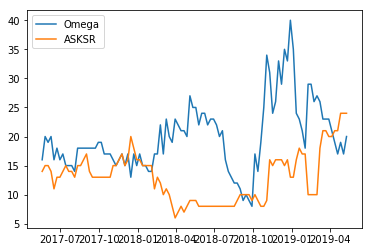

In [88]:
plt.plot(mOmega_ranking_df.index,wOmega_ranking_df["XLB"],wASKSR_ranking_df.index,wASKSR_ranking_df["XLB"])
plt.legend(labels = ['Omega', 'ASKSR'], loc = 'best')


In [70]:
mASKSR_ranking_df.XLB.corr(mOmega_ranking_df.XLB)

0.21262596441981219

In [75]:
mOmega_df

,XLB,IYM,IGE,VAW,PKB,XHB,ITB,GDX,XME,MXI,...,NANR,VOX,ERUS,IYZ,FCOM,IXP,XTL,WBIF,FONE,LTL
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-01,1.277626,1.160607,0.731351,1.301100,1.556227,1.342283,1.519931,1.170973,0.963002,1.038535,...,NaN,1.421084,0.930165,1.329921,1.719610,1.121308,1.661283,NaN,1.761180,1.293394
2017-08-01,1.253093,1.129454,0.656668,1.266962,1.524442,1.291638,1.500312,1.055149,0.931370,0.996065,...,NaN,1.316117,0.874252,1.239119,1.580226,1.029487,1.520523,NaN,1.589715,1.218801
2017-09-01,1.335309,1.222277,0.720785,1.361904,1.737684,1.555285,1.848726,1.077690,0.965103,1.107976,...,NaN,1.384008,0.980227,1.236752,1.679951,1.142915,1.736510,NaN,1.743153,1.165094
2017-10-01,1.289310,1.185376,0.668914,1.310925,1.602549,1.403454,1.667701,1.116472,0.967955,1.141554,...,NaN,1.375221,1.064850,1.231045,1.668561,1.055269,1.535660,1.168413,1.658114,1.158446
2017-11-01,1.433078,1.337556,0.812682,1.499452,2.033590,1.694742,2.054953,1.203491,1.067632,1.300647,...,NaN,1.419193,1.170548,1.193853,1.714325,1.155121,1.681873,1.321717,1.954124,1.092038
2017-12-01,1.512538,1.415035,0.839461,1.560114,2.026191,1.632226,2.074092,1.352847,1.069935,1.392270,...,NaN,1.213560,1.167562,1.072402,1.476389,1.028089,1.484357,1.360341,1.933993,1.161062
2018-01-01,1.482431,1.403227,0.932632,1.537554,2.165717,1.600107,2.096785,1.244799,1.119201,1.376564,...,NaN,1.290762,1.309638,1.102301,1.548840,1.077400,1.524458,1.377065,1.888385,1.064969
2018-02-01,1.522940,1.462138,0.991610,1.570910,2.141230,1.557041,2.090358,1.331810,1.264707,1.504037,...,NaN,1.350058,1.707100,1.106215,1.604839,1.226514,1.425250,1.560032,1.914421,1.076625
